# Introduction #

Большинство методов, с которыми мы познакомились в этом курсе, были предназначены для числовых объектов. Метод, который мы рассмотрим в этом уроке, *целевое кодирование*, предназначен для категориальных объектов. Это метод кодирования категорий в виде чисел, похожий на однократное или меточное кодирование, с той разницей, что для создания кодировки также используется *target*. Это делает его тем, что мы называем *контролируемым* методом разработки функций.

In [2]:
import pandas as pd

autos = pd.read_csv("autos.csv")

# Target Encoding #

A **target encoding** это любой вид кодировки, который заменяет категории объектов некоторым числом, полученным из целевого значения.

Простой и эффективный вариант - применить групповую статистику из урока 3, например, среднее значение. Используя *Automobiles* в наборе данных вычисляется средняя цена для каждой марки транспортного средства:

In [3]:
autos["make_encoded"] = autos.groupby("make")["price"].transform("mean")

autos[["make", "price", "make_encoded"]].head(10)

,make,price,make_encoded
0,alfa-romero,13495,15498.333333
1,alfa-romero,16500,15498.333333
2,alfa-romero,16500,15498.333333
3,audi,13950,17859.166667
4,audi,17450,17859.166667
5,audi,15250,17859.166667
6,audi,17710,17859.166667
7,audi,18920,17859.166667
8,audi,23875,17859.166667
9,bmw,16430,26118.750000


Этот вид целевого кодирования иногда называют **mean encoding**. Применяемый к бинарному целевому объекту, он также называется **bin counting**. (Другие названия, с которыми вы можете столкнуться, включают в себя: вероятностное кодирование, кодирование воздействия и одноразовое кодирование.)

# Smoothing #

Однако подобная кодировка сопряжена с рядом проблем. Во-первых, это *неизвестные категории*. Целевые кодировки создают особый риск переобучения, что означает, что их необходимо обучать независимому разделению "кодировок". Когда вы присоедините кодировку к будущим разделениям, Pandas заполнит пропущенные значения для любых категорий, отсутствующих в разделении кодировки. Эти пропущенные значения вам придется как-то вычислить.

Во-вторых, это *rare categories*. Если категория встречается в наборе данных всего несколько раз, любая статистика, рассчитанная по ее группе, вряд ли будет очень точной. В *Automobiles* dataset, the `mercurcy` изменение происходит только один раз. "Средняя" цена, которую мы рассчитали, - это всего лишь цена одного транспортного средства, которая может не очень точно отражать любые изменения, которые мы можем увидеть в будущем. Целевые категории скорости кодирования могут повысить вероятность переобучения.

Решением этих проблем является добавление **smoothing**. Идея состоит в том, чтобы смешать *in-category* среднее значение с учетом*overall* средний. Редкие категории получают меньший вес в среднем по своей категории, в то время как отсутствующие категории получают только общее среднее значение.

In pseudocode:
```
encoding = weight * in_category + (1 - weight) * overall
```
Когда `weight` это значение от 0 до 1, рассчитанное исходя из частоты использования категории.

Простой способ определить значение для `weight` состоит в том, чтобы вычислить **m-estimate**:
```
weight = n / (n + m)
```
Когда `n` это общее количество раз, когда данная категория встречается в данных. Параметр `m` определяет "коэффициент сглаживания". Большие значения `m` придайте больше значения общей оценке.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/1uVtQEz.png" width=500, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

В *Automobiles* в наборе данных есть три автомобиля с маркой `chevrolet`. Если мы выберем `m=2.0`, Тогда `chevrolet` в категорию будет включено 60% от средней цены Chevrolet плюс 40% от общей средней цены.
```
chevrolet = 0.6 * 6000.00 + 0.4 * 13285.03
```

При выборе значения для `m`,подумайте, насколько шумными, по вашему мнению, должны быть категории. Сильно ли различается цена автомобиля в зависимости от марки? Потребуется ли вам много данных для получения точных оценок? Если да, то, возможно, лучше выбрать более высокую стоимость для `m`; если бы средняя цена на каждую марку была относительно стабильной, можно было бы предложить меньшую стоимость.

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<strong>Варианты использования для целевой кодировки</strong><br>
Целевая кодировка отлично подходит для:
<ul>
<li><strong>Функции с высокой мощностью</strong>: Кодирование функции с большим количеством категорий может быть затруднено: однократное кодирование привело бы к появлению слишком большого количества функций, а альтернативные варианты, такие как кодировка меток, могут не подходить для этой функции. Целевая кодировка выводит номера для категорий, используя наиболее важное свойство объектов: их связь с целевой кодировкой.
<li><strong>Функции, ориентированные на предметную область</strong>: Исходя из предыдущего опыта, вы можете предположить, что категориальный признак должен быть важным, даже если он имеет низкую оценку по показателю признака. Целевая кодировка может помочь выявить истинную информативность признака.
</ul>
</blockquote>

# Example - MovieLens1M #

The [*MovieLens1M*](https://www.kaggle.com/grouplens/movielens-20m-dataset) набор данных содержит миллион оценок фильмов пользователями веб-сайта MovieLens, а также характеристики, описывающие каждого пользователя и фильм. Эта скрытая ячейка настраивает все параметры:

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


df = pd.read_csv("movielens1m.csv")
df = df.astype(np.uint8, errors='ignore') # reduce memory footprint
print("Number of Unique Zipcodes: {}".format(df["Zipcode"].nunique()))

Number of Unique Zipcodes: 3439


Имея более 3000 категорий, компания `Zipcode` функция является хорошим кандидатом для целевой кодировки, а размер этого набора данных (более миллиона строк) означает, что мы можем сэкономить часть данных для создания кодировки.

Для начала мы создадим разделение на 25% для обучения целевого кодировщика.

In [2]:
X = df.copy()
y = X.pop('Rating')

X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

The `category_encoders` package in `scikit-learn-contrib` реализует кодировщик m-оценок, который мы будем использовать для кодирования нашего `Zipcode` feature.

In [4]:
from category_encoders import MEstimateEncoder

# Создайте экземпляр кодировщика. Выберите m для управления уровнем шума.
encoder = MEstimateEncoder(cols=["Zipcode"], m=5.0)

# Установите кодировщик на разделитель кодировки.
encoder.fit(X_encode, y_encode)

#Закодируйте столбец почтового индекса, чтобы создать окончательные обучающие данные
X_train = encoder.transform(X_pretrain)

Давайте сравним закодированные значения с целевыми, чтобы увидеть, насколько информативной может быть наша кодировка.

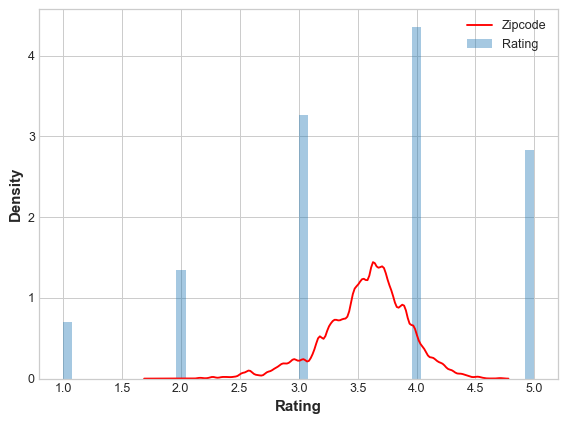

In [5]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train.Zipcode, color='r', ax=ax)
ax.set_xlabel("Rating")
ax.legend(labels=['Zipcode', 'Rating']);

Распределение закодированной функции "Почтовый индекс" примерно соответствует распределению фактических оценок, а это означает, что оценки зрителей фильмов достаточно сильно различались от почтового индекса к почтовому индексу, чтобы наша целевая кодировка могла содержать полезную информацию.